[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/computationalpharmaceutics/3FG005/blob/main/Lab01_peptide_aggregation/LAB_01_peptide_aggregation_GPU_T4.ipynb)

# Peptide aggregation simulation

This exercise demonstrates the use of all-atom molecular dynamics simulations with GROMACS for analyzing peptide aggregation

Throughout the exercise, there are questions that you should answer for the report. This has no set page limit but 1-3 pages might be appropriate. After you have finished, please submit your report to Studium.

# Important:

Before start with this lab click in the edit menu and select clear all outputs

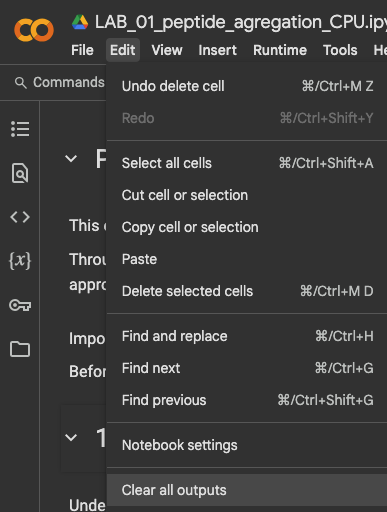

Go to the menu 'Runtime' and select the option 'Change runtime type'.

Then select 'T4 GPU' under the hardware accelerator options:  

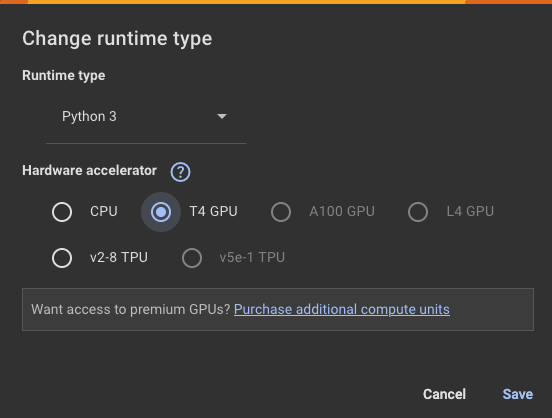

# 1. Introduction

Understanding of peptide aggregation propensity is an important aspect in pharmaceutical development of peptide drugs. In this exercise, methodologies based on all-atom molecular dynamics (AA-MD) simulations and 1 H-NMR (which was run in neat H2 O) will be evaluated as tools for identification and investigation of peptide aggregation. A series of structurally similar, pharmaceutically relevant peptides with known differences in aggregation behavior (D‑Phe6 ‑GnRH, ozarelix and cetrorelix) will be investigated.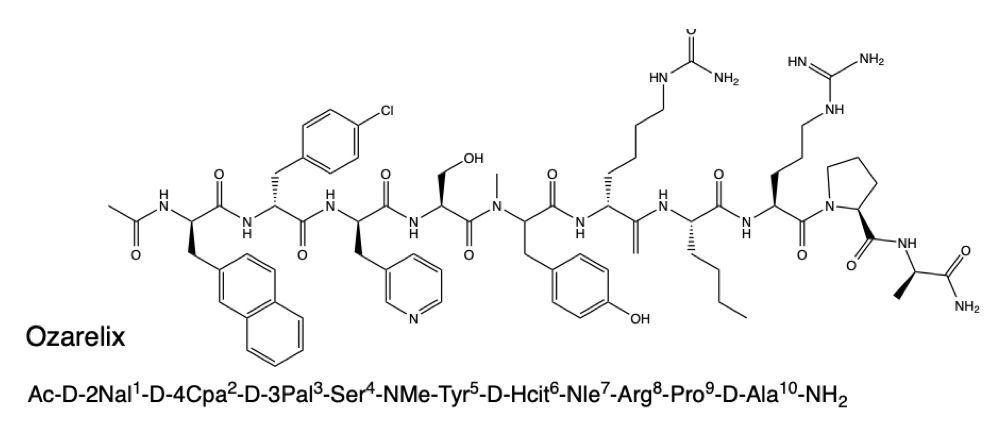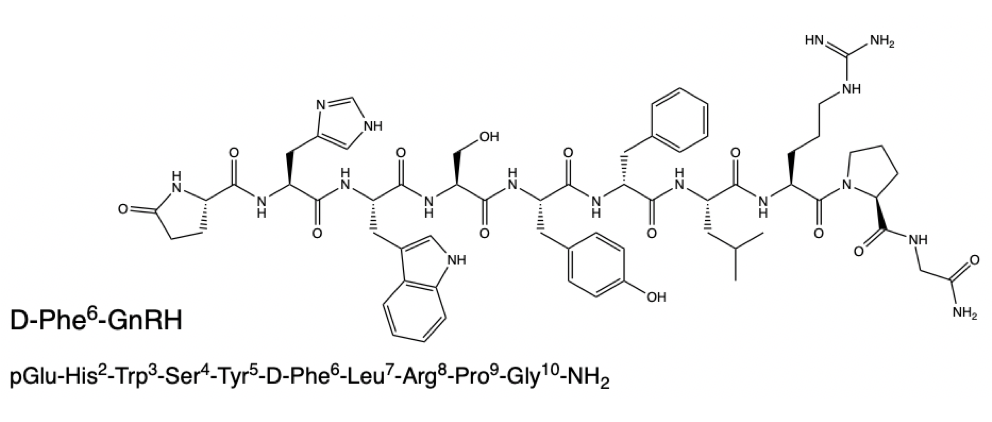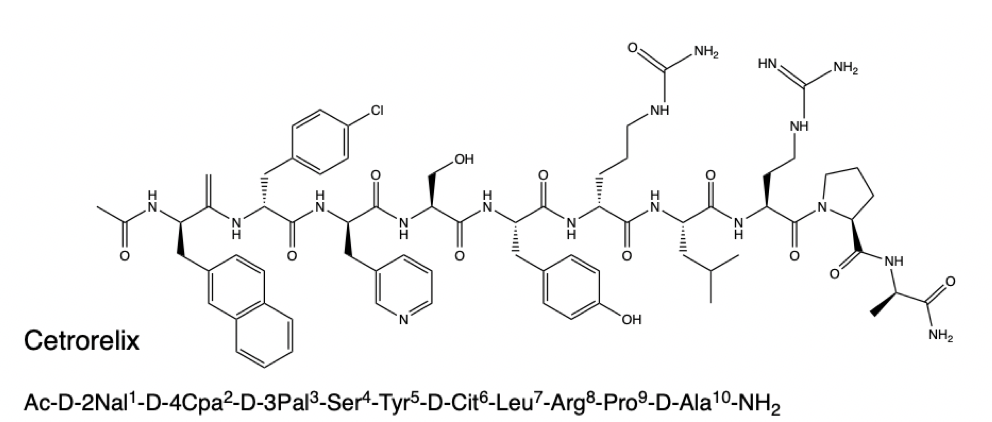

# 2. Background

The aggregation behaviour of therapeutic peptides influences several critical aspects of pharmaceutical development, such as the dosage forms possible to develop, ease of manufacturing, formulation stability, and patient safety and convenience. Self-assembly is often an unwanted effect, but can also be utilized to alter the pharmacokinetics of peptide and protein drugs and can improve the chemical and physical stability of the drug. When peptides self-assemble, they can, similarly to proteins, form various types of aggregates. The two aggregate types most commonly discussed for therapeutic peptides are:

-  1) amyloid-like fibrils, where the peptide chains are folded into stacked beta-sheets
-  2) amorphous aggregates, i.e. disordered structures.

Amyloid-like fibrils are known to be preceded by smaller aggregates, e.g. oligomers or fibril fragments (proto-fibrils or filaments) and some peptides can form stable, well-defined oligomers. It is likely that transient oligomers, which may involve just a few molecules, play a role in the formation of larger aggregates (for short-lived oligomers, it can be debated what should be regarded as aggregates or simply attractive peptide-peptide interactions in solution). Transient oligomers may be particularly relevant for small peptides, which often show high conformational flexibility and a notably amphiphilic character.

To obtain a good understanding of the aggregation behavior of a peptide, methods that can distinguish aggregates of different character and size are of importance.

# 3. Setting up the computing environment

In [ ]:
# Installing necessary packages
!pip install py3Dmol

In [ ]:
# Cloning the course repository
!git clone https://github.com/computationalpharmaceutics/3FG005.git

In [ ]:
# If GPU available, copying the gromacs_intall.tar.gz file from the path to the content file
!cp /content/3FG005/Lab01_peptide_aggregation/GROMACS_GPU_T4/gromacs_install.tar.gz /content

In [ ]:
# Unpacking the file gromacs_install.tar.gz  and creating the folder:  /usr/local/gromacs
!tar -xzf /content/3FG005/Lab01_peptide_aggregation/GROMACS_GPU_T4/gromacs_install.tar.gz -C /

In [ ]:
# Confirm it's installed
!/usr/local/gromacs/bin/gmx --version

In [ ]:
# Seting the path to GROMACS
import os
os.environ["PATH"] += ":/usr/local/gromacs/bin"

# Looking for the working directory
!pwd

In [ ]:
# Changing the working directory to

import os
os.chdir('/content/3FG005/Lab01_peptide_aggregation/GROMACS_GPU_T4/Cetrorelix')
!pwd

# 4 Assembling the system

The first step in most molecular simulations is assembling an initial system configuration (coordinates) as well as topologies (force field interaction parameters) for all molecules in the system. Depending on the molecules, either the initial coordinates, the topology or both can require a substantial amount of work as well as in-depth knowledge.

For this exercise you will be working with topologies that have been prepared in advance, and will only be required to update certain parts in the provided files.

We will however do the work to obtain the initial system configuration, and for this will be using built-in gromacs tools.

In [ ]:
# Looking at the initial files :
!ls

In [ ]:
# Visualizing the contents of the cetrorelix_single_molecule.gro file
with open('cetrorelix_single_molecule.gro', 'r') as file:
    for i in range(100):
        print(file.readline(), end='')

In [ ]:
# Transforming the cetrorelix_single_molecule.gro to a cetrorelix_single_molecule.pbd file
!gmx editconf -f cetrorelix_single_molecule.gro -o cetrorelix_single_molecule.pdb

In [ ]:
# Looking at the generated files
!ls

In [ ]:
# Visualizing the cetrorelix_single_molecule.pdb
import py3Dmol
with open('cetrorelix_single_molecule.pdb', 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'sphere': {'color': 'spectrum'}})
view.zoomTo()
view.show()

Gromacs has a lot of built-in tools for both construction of different systems as well as tools for post-processing and analysis of trajectories. Here will be using the insert-molecules feature to create a simulation box and insert 6 copies of the peptide into it:


***!gmx insert-molecules -ci cetrorelix_single_molecule.gro -box 10 10 10 -nmol 6 -o system.gro***


This command will generate a file named as 'system.gro' which has a simulation box with a size of 10 nm in the x-, y- and z- direction and contains 6 Cetrorelix molecules in the box. This 6 molecules will represent approximately 10 mM concentration of peptides in the box.

In [ ]:
# Creating a box
!gmx insert-molecules -ci cetrorelix_single_molecule.gro -box 10 10 10 -nmol 6 -o system.gro

In [ ]:
# Looking the generated files
!ls

In [ ]:
# Convert the system.gro file to system.pdb for visualization purposes
!gmx editconf -f system.gro -o system.pdb

In [ ]:
# Looking the generated files
!ls

In [ ]:
# Visualizing the system

# Load the converted PDB file
pdb_data = open('system.pdb','r').read()

view = py3Dmol.view(width=800, height=500)
view.addModel(pdb_data, 'pdb')
view.setStyle({'sphere': {'color': 'spectrum'}})
view.addUnitCell()
view.zoomTo()
view.show()

In [ ]:
# looking at the cetrorelix_simulation.top file
with open('cetrorelix_simulation.top', 'r') as file:
    for i in range(100):
        print(file.readline(), end='')

We then also need to solvate the system using water as solvent using the solvate command:

***!gmx solvate -cp system.gro -cs spc216.gro -o system_solv.gro -p cetrorelix_simulation.top***

This will generate a new gro file named as 'system_solv.gro' which will add water in the simulation. This command will also make changes in the 'cetrorelix_simulation.top' file. After the line where the number of proteins were mentioned, there will be another line starting with 'SOL' followed by the number of water molecules that were added in the system.

- gmx solvate calls the GROMACs module 'solvate' to add a solvent to the simulation box.
- -cp system.gro is the input file.
- -cs spc216.gro is the water molecule model that will be used as a solvent.
- -o system_solv.gro is output file.
- -p cetrorelix_simulation.top is topology file that will be updated to include the water molecules added to the system.






In [ ]:
# Adding solvate to the system
!gmx solvate -cp system.gro -cs spc216.gro -o system_solv.gro -p cetrorelix_simulation.top

In [ ]:
# Looking the generated files
!ls

In [ ]:
# Downloading the system_solv.gro
from google.colab import files
files.download('system_solv.gro')

Download and install the software VMD:


[VMD](https://www.ks.uiuc.edu/Research/vmd/alpha/)

Use VMD to open the file system_solv.gro to visualize the solvated system.
- Click the 'Browse' box to look for the ***system_solv.gro*** file (mostly saved in the Downloads folder)
- Once the file is located, select it with the mouse, click the 'OK' box, and then click the 'Load' box.
- Rotate the simulation box using the mouse to inspect it from different angles.

The expected output will be:


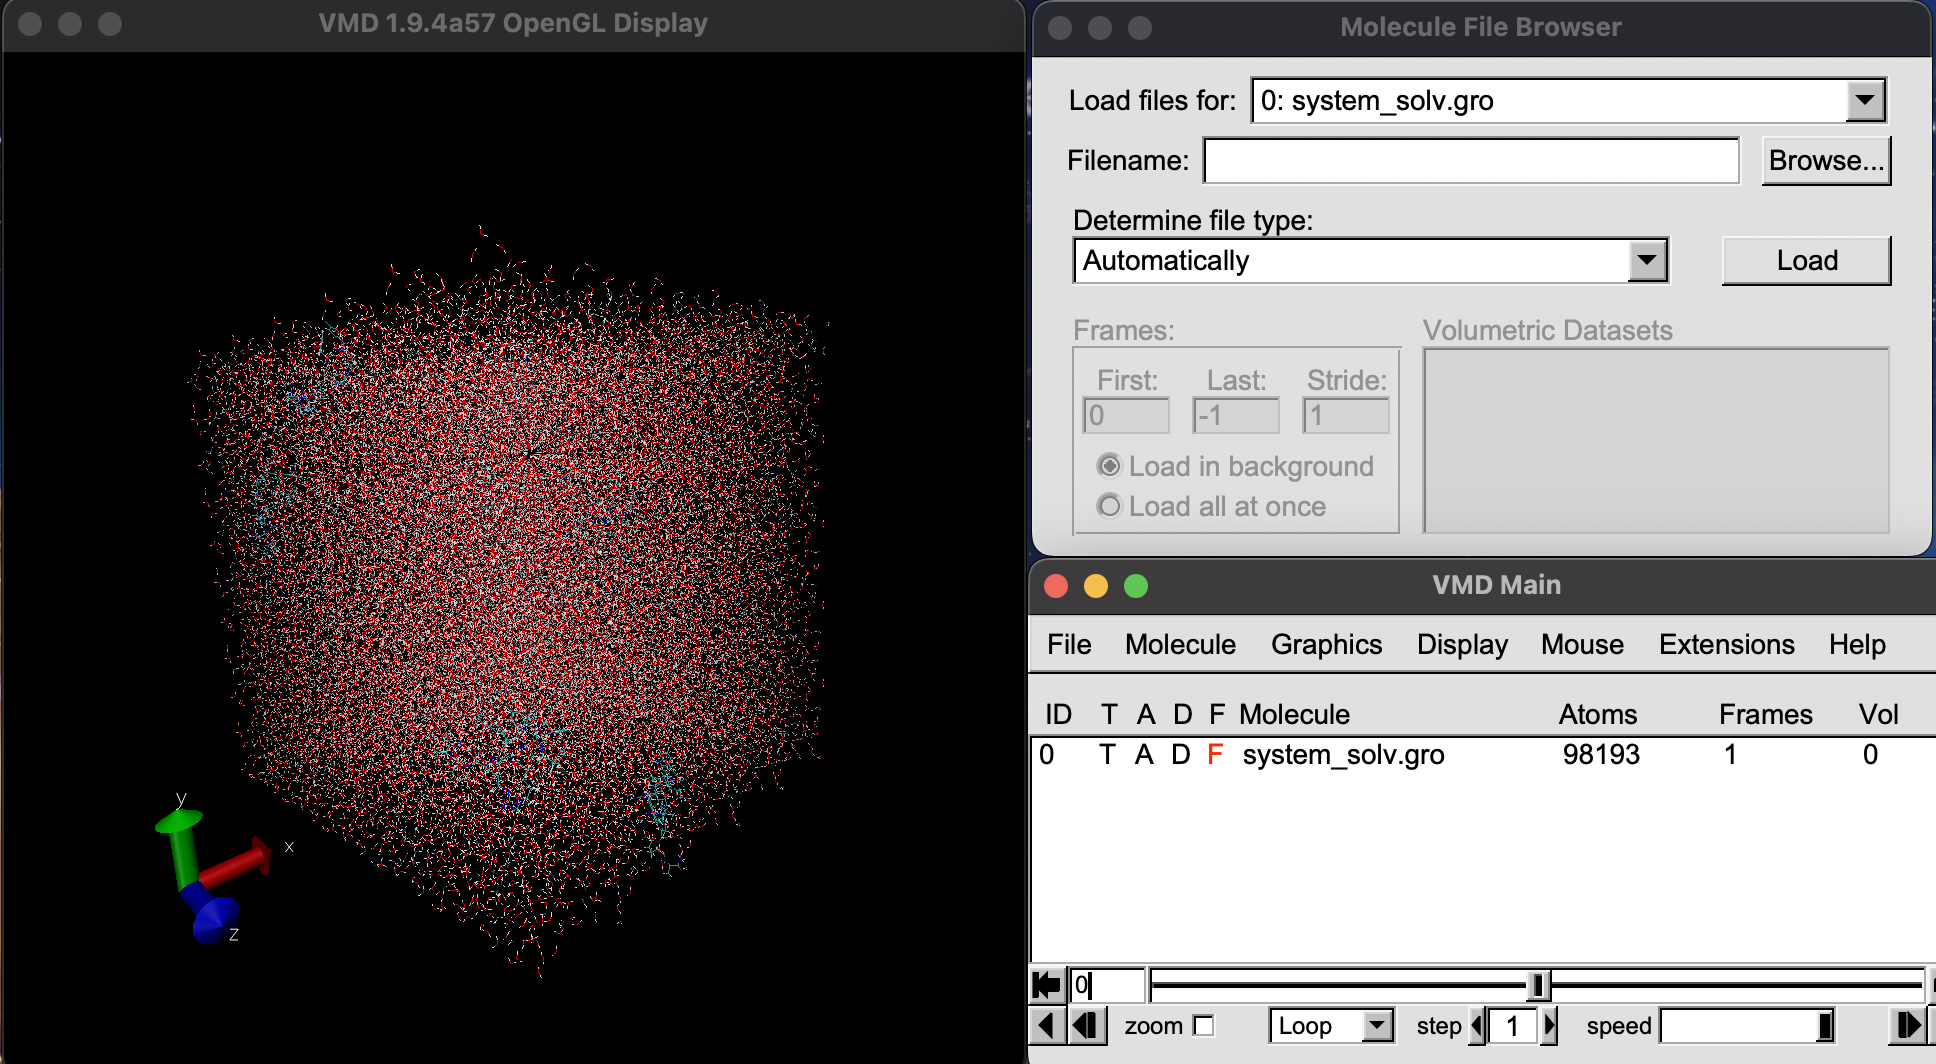

Once the file system_solv is created, you will need to add ions to the system to make the system neutral. The molecule Cetrorelix contains a total charge of +1. So, the total charge of the system is now +6 (since we added 6 cetrorelix molecules). We will now add 6 Chlorine ions each having a charge of -1.

Use the following command to create a topology parser file (ions.tpr) that contains all the force field information and coordinates to add the six Chloride ions

***!gmx grompp -f em.mdp -c system_solv.gro -r system_solv.gro -p cetrorelix_simulation.top -o ions.tpr -maxwarn 1 ***

- -f em.mdp is the input parameter file to be used for minimization later.
- -c system_solv.gro is the solvated system
- -r system_solv.gro is the reference structure that contains the molecule positions.
- -p cetrorelix_simulation.top is the topology file with the system description.
- -o ions.tpr is the output file that will later be used by the module 'genion'.
- -maxwarn 1 is the command to manage the warnings

In [ ]:
# Creating the topology parser file: ions.tpr
!gmx grompp -f em.mdp -c system_solv.gro -r system_solv.gro -p cetrorelix_simulation.top -o ions.tpr -maxwarn 1

In [ ]:
# Looking the generated files
!ls

Then, use the following command to add six chloride ions and neutralize the system.

***!echo "SOL" | gmx genion -s ions.tpr -o system_solv_ion.gro -p cetrorelix_simulation.top -pname NA -nname CL -neutral***

- echo "SOL" is the command to select the group of solvent molecules that will be replaced with the chloride ions.
- gmx genion is the GROMACS module to add the chloride ions.
- -s ions.tpr is the input topology parser file that contains forcefield information.
- -o system_solv_ion.gro is the output file.
-	-p cetrorelix_simulation.top is the topology file that will be updated with the six chloride ions.
- -pname NA is the name of the positive ion (Na+) that might be used to neutralize the system.
-  -pname CL is the name of the negative ion (Cl-) that might be used to neutralize the system.
- -neutral is the command that confirms the ion addition until the system becomes electrically neutral.

In [ ]:
# Adding ions automatically to neutralize
!echo "SOL" | gmx genion -s ions.tpr -o system_solv_ion.gro -p cetrorelix_simulation.top -pname NA -nname CL -neutral

In [ ]:
# Looking the generated files
!ls

In [ ]:
# Downloading the system_solv_ion.gro
from google.colab import files
files.download('system_solv_ion.gro')

Use VMD to open the file system_solv_ion.gro to visualize the neutralized system.

- Click the Browse box to look for the ***system_solv_ion.gro***  file (mostly saved in the Downloads folder)
- Once the file is located, select it with the mouse, click the 'OK' box, and then click the 'Load' box.
- Select the menu Grapichs/Representations in the window called 'VMD main'. This will open a new window called 'Graphical Representations'.


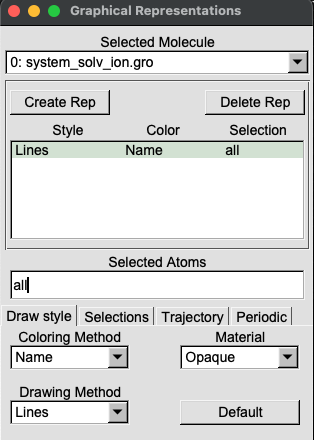

- Press the box 'Create Rep', and a new row will appear under the Style-Color-Selection box

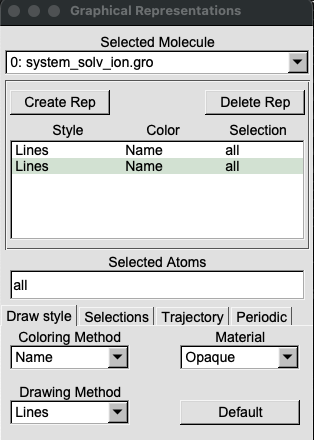

- Erase the word 'all' in the 'Selected Atoms' box, write 'protein', and click the box "Apply'.
- Change the Drawing Method from 'Lines' to 'VDW', and click the box Apply.

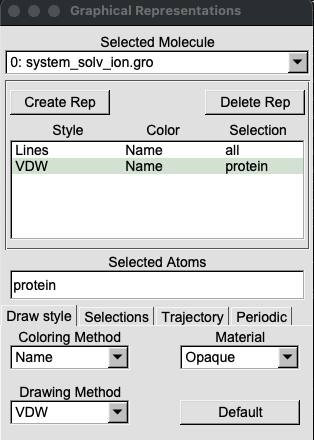

- Press the box 'Create Rep', and a new row will appear under the Style-Color-Selection box.
- Erase the word 'all' in the 'Selected Atoms' box, write **'resname CL'**, and click the box "Apply'.
Change the Drawing Method from 'Lines' to 'VDW', and click the box Apply

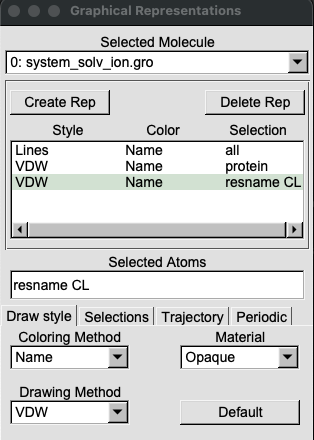

- Rotate the simulation box using the mouse to inspect it from different angles.
- Visualize the six spherical green ions in the simulation box

The expected output will be:

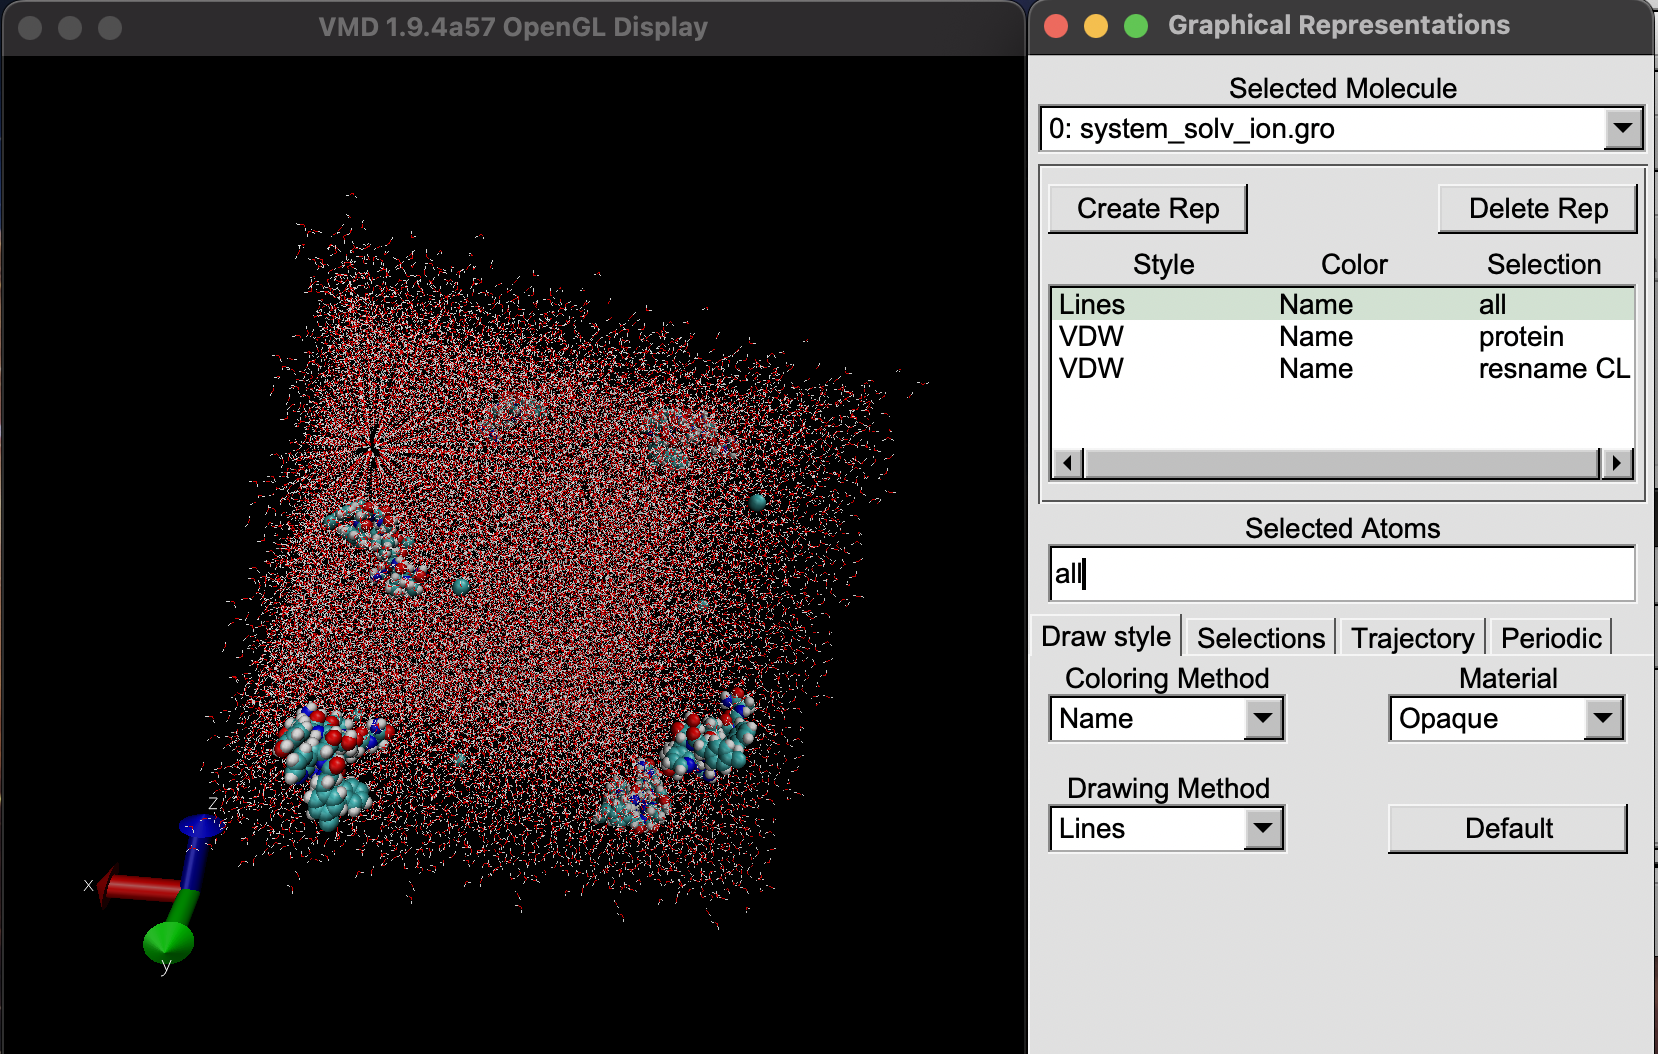

# 5. Energy minimization

Following construction of the initial system we need to go though the processes of energy minimization and equilibration, in two separate steps.

For energy minimization and equilibration, in addition to the system coordinates and topology we also need a third file, with details about what we want to do and how it should be done. These files end with .mdp. Before proceeding, open one of these files and look at its contents

In [ ]:
# Looking at the generated files
!ls

In [ ]:
# looking at the em.mdp file
with open('em.mdp', 'r') as file:
    for i in range(100):
        print(file.readline(), end='')

# Question:

Q1.- Explain the meaning of the folowing variables in the em.mdp file:

- nsteps
- rvdw
- rcoulomb

We start with energy minimization by using the following command:

***!gmx grompp -f em.mdp -c system_solv_ion.gro -r system_solv_ion.gro -p cetrorelix_simulation.top -o em.tpr***



- gmx grompp is the GROMACS command that compile the simulation input files (parameters, structure, reference positions, topology)  and will create an em.tpr file that will be used to run the energy minimization in the next step.

- -f em.mdp is the parameter file that contains the details of the minimization procedure.

- -c system_solv_ion.gro is the structure file that contains information about the solvated and neutralized system.

- -r system_solv_ion.gro is the reference structure file for applying position restraints.

- -p cetrorelix_simulation.top is the topology file that describes the force field parameters, molecule types, and quantities.

- -o em.tpr is the topology parser output file to be used in the next step.



In [ ]:
# Generating the em.tpr file needed to perform the energy minimization
!gmx grompp -f em.mdp -c system_solv_ion.gro -r system_solv_ion.gro -p cetrorelix_simulation.top -o em.tpr

In [ ]:
# Looking at the generated files
!ls

The following command will actually run the energy minimization simulation. This step will take a while. If everything went ok, you should see a lot of output on the screen followed by a section at the end with some summary statistics about the run.

In [ ]:
import time

start_time = time.time()

# Run the GROMACS energy minimization
!gmx mdrun -v -deffnm em

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nEnergy minimization completed in {elapsed_time:.2f} seconds.")

This will also generate a number of files with the information about the energy minimization simulation.

In [ ]:
# Looking at the generated files
!ls

The following command will allow you to prompt a number that corresponds to the potential energy. At the prompt, type '12 0' to select Potential (12); and zero (0) terminates input. This will generate a file named as 'potential.xvg'.

Use the following command:

***!gmx energy -f em.edr -o potential.xvg***

In [ ]:
# Obtaining the energy minimization profile
!gmx energy -f em.edr -o potential.xvg

Make a plot of the potential energy vs time and include in your report.

# Questions:

Q2.- Does the potential energy seem to reach a stationary value?

Q3.- What is the purpose of energy minimization as part of setting up a molecular dynamics simulation?

In [ ]:
# Visualizing the potential.xvg file
import matplotlib.pyplot as plt
import numpy as np
filename= 'potential.xvg'

# Function to read xvg files
def read_xvg(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip() and not line.startswith(('#', '@')):
                data.append([float(x) for x in line.split()])
    return np.array(data)

# Load your potential energy file
data = read_xvg('potential.xvg')
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data[:,0], data[:,1], '-')
plt.xlabel('Energy Minimization Step')
plt.ylabel('Potential Energy (kJ/mol)')
plt.title('Potential Energy Convergence')
plt.grid(True)
plt.show()

# 6. Equilibration

Following energy minimization we proceed to equilibration. The purpose of this step is to make sure that other important variables such as system temperature, density and pressure have reached their intended values and appear stable. This is done in two steps. The first phase is conducted under an NVT ensemble (constant Number of particles, Volume, and Temperature) and using the following commands which are similar to the energy minimization steps:

Use the following comand:

***!gmx grompp -f nvt.mdp -c em.gro -r em.gro -p cetrorelix_simulation.top -o nvt.tpr***

In [ ]:
# Confirming that system temperature, density, and pressure have reached their intended values and appear stable
!gmx grompp -f nvt.mdp -c em.gro -r em.gro -p cetrorelix_simulation.top -o nvt.tpr

This will generate a 'nvt.tpr' file Then, using that 'nvt.tpr' file, we start the actual equilibration simulation by running the command

Use the following command:

***!gmx mdrun -v -s nvt.tpr -deffnm nvt***

In [ ]:
# start equilibration with the generated 'nvt.tpr' file

start_time = time.time()

!gmx mdrun -v -s nvt.tpr -deffnm nvt

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nEquilibration completed in {elapsed_time:.2f} seconds.")

Once the NVT equilibration is done, we can obtain the temperature profile y running the following command:

***!gmx energy -f nvt.edr -o temperature.xvg***

Like the potential energy, this will prompt you to type a number corresponding to temperature. Find the number and type as previous. This will then generate a file named 'temperature.xvg'.


In [ ]:
# Obtaining the temperature profile: temperature.xvg

!gmx energy -f nvt.edr -o temperature.xvg

In [ ]:
# Plot Temperature Vs Time
time = []
temperature = []

# Read the .xvg file
with open("temperature.xvg", "r") as f:
    for line in f:
        # Skip comments and metadata lines
        if line.startswith(("#", "@")):
            continue
        # Extract data columns
        parts = line.strip().split()
        if len(parts) >= 2:
            time.append(float(parts[0]))         # Time (ps)
            temperature.append(float(parts[1]))  # Temperature (K)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(time, temperature, label="Temperature", linewidth=1.5)
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

the pressure and density profiles can be obtained by running the following commands

In [ ]:
!ls

Then we perform the second step of the equilibration such as equilibration of pressure, which is conducted under an NPTensemble, wherein the Number of particles, Pressure, and Temperature are all constant. Use the following commands:

Use the following command:

***!gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -p cetrorelix_simulation.top -o npt.tpr***




In [ ]:
!gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -p cetrorelix_simulation.top -o npt.tpr

Then, use the following command:

***!gmx mdrun -v -s npt.tpr -deffnm npt***

In [ ]:
!gmx mdrun -v -s npt.tpr -deffnm npt

Once this simulation is done, the pressure and density profiles can be obtained by running the following commands:


***!gmx energy -f npt.edr -o pressure.xvg***

***!gmx energy -f npt.edr -o density.xvg***



In [ ]:
# Obtaining the pressure profile
!gmx energy -f npt.edr -o pressure.xvg


In [ ]:
# Looking at the generated files
!ls

In [ ]:
# Ploting Pressure vs Time
time = []
pressure = []

# Read the .xvg file
with open("pressure.xvg", "r") as f:
    for line in f:
        if line.startswith(("#", "@")):
            continue  # Skip comments and metadata
        parts = line.strip().split()
        if len(parts) >= 2:
            time.append(float(parts[0]))        # Time (ps)
            pressure.append(float(parts[1]))    # Pressure (bar)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(time, pressure, label="Pressure", color="orange", linewidth=1.5)
plt.xlabel("Time (ps)")
plt.ylabel("Pressure (bar)")
plt.title("Pressure vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Obtaining the density profile
!gmx energy -f npt.edr -o density.xvg

In [ ]:
# Ploting Density vs Time
time = []
density = []

# Read the .xvg file
with open("density.xvg", "r") as f:
    for line in f:
        if line.startswith(("#", "@")):
            continue  # Skip metadata
        parts = line.strip().split()
        if len(parts) >= 2:
            time.append(float(parts[0]))       # Time (ps)
            density.append(float(parts[1]))    # Density (kg/m^3)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(time, density, label="Density", color="green", linewidth=1.5)
plt.xlabel("Time (ps)")
plt.ylabel("Density (kg/m³)")
plt.title("Density vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Once your equilibration is finished , similar to the plot of potential energy vs time, include in your report a plot of your choice of two of temperature, pressure, and density vs time.

After the equilibration simulation is done, we can start the final production simulation. To run the final production simulation, we will use 'md.mdp' file.

# Question

Q4. What would be the commands for setting up the final production run?

Hint: Follow the previous commands used in energy minimization or equilibration


As you might have noticed, this equilibration for 0.1 ns took almost 30 minutes time. To be able to do a few different analysis, we have provided ready-made trajectories of the same systems that are
 significantly longer than what we can realistically run during this exercise.

Download the trajectories files from:

[Analysis](https://uppsala.instructure.com/courses/64626/files/3151959?wrap=1)

Unzip the Analysis-2.zip file on your local computer and upload it to your Google Drive account.

The expected output will be a folder called Analysis inside the 'My Drive' folder



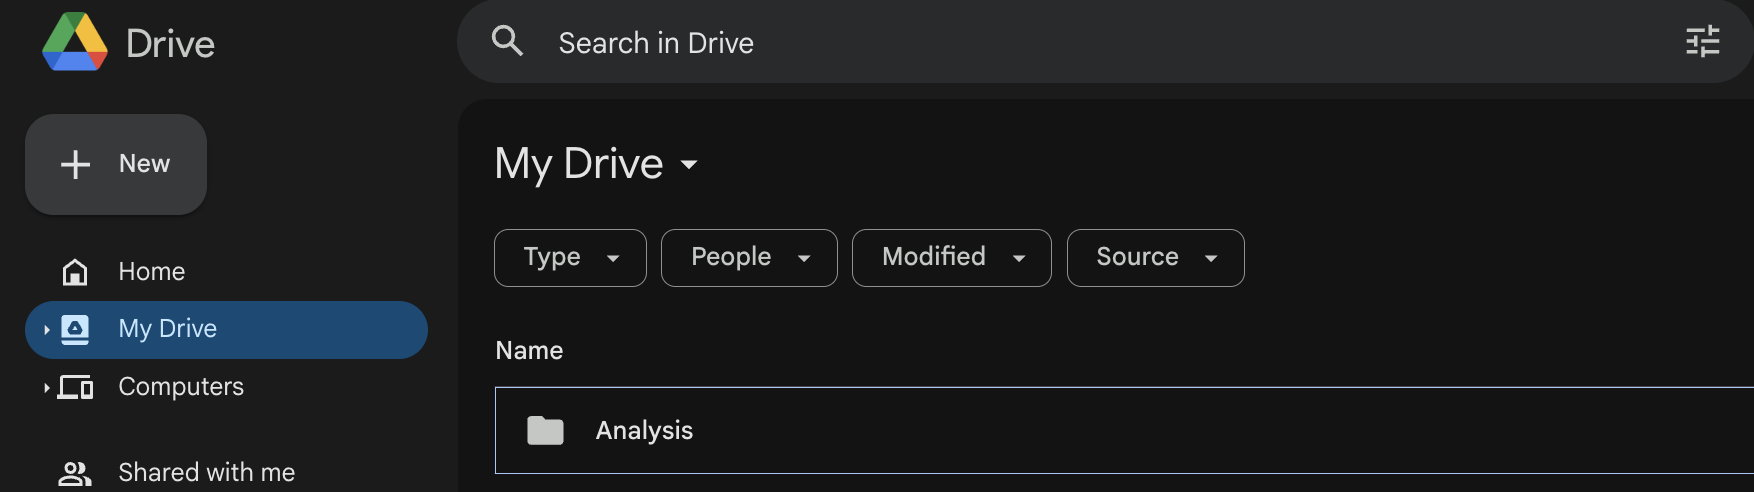

Connect your Google Drive account to this notebook by running the following code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Changing the working directory to Cetrorelix
import os
os.chdir('/content/drive/MyDrive/Analysis/Hydrogen_bonding/Cetrorelix')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Hydrogen_bonding/Cetrorelix folder
!ls

We will now be doing a few different analysis on these trajectories using ready-made scripts to automate the process to a degree at least.

# 7. Analysis
## 7.1 Hydrogen bonding

Inside the 'Hydrogen_bonding' folder you will find four different folder for four different peptides with each containing data for the last 100 ns of the simulation (400-500 ns). We will perform hydrogen binding analysis on this last 100 ns simulation trajectory. First navigate to the folder 'Cetrorelix'.

Then run the following command to obtain the protein-protein (peptide-peptide) hydrogen bonding

***!gmx hbond -f last100ns_cetro.xtc -s md.tpr -n index.ndx -num pro-pro.xvg***

This command will prompt you to type two groups for which you wish to calculate the hydrogen bonding. You first type 1 and then hit enter and again type 1 and hit enter. The number 1 here represent the proteins if you read carefully the screen. This will generate an output file pro-pro.xvg which contains the number of hydrogen bonds in each time steps in the second column. The first column in the time steps.

In [ ]:
# obtaining the protein-protein (peptide-peptide) hydrogen bonding
!gmx hbond -f last100ns_cetro.xtc -s md.tpr -n index.ndx -num pro-pro.xvg

Then you run the following command which will give you the average values of the peptide-peptide hydrogen bonds in the screen for this last 100 ns time for cetrorelix. Take note of this average value and their standard deviation.

***!gmx analyze -f pro-pro.xvg***

In [ ]:
# obtaining the average values of the peptide-peptide hydrogen bonds
!gmx analyze -f pro-pro.xvg

Then, we will calculate the peptide water hydrogen bonding. Run the following command:

***!gmx hbond -f last100ns_cetro.xtc -s md.tpr -n index.ndx -num pro-water.xvg***

Now when this command prompt you to type two groups, you type first 1 and then 12 in a similar fashion. Note that, 1 represents protein, and 12 represents water. This will generate a file named prowater.xvg which contains the peptide-water hydrogen bonds.

In [ ]:
# obtaining the protein-water (peptide-water) hydrogen bonding
!gmx hbond -f last100ns_cetro.xtc -s md.tpr -n index.ndx -num pro-water.xvg

Then run the following command to get the average value of peptide-water hydrogen bonds.

***!gmx analyze -f pro-water.xvg***

Take note of this average value and their standard deviation.

In [ ]:
# obtaining the average values of the peptide-water hydrogen bonds
!gmx analyze -f pro-water.xvg

Now, in a similar way, navigate to the other folders i.e. ozarelix, D-Phe-Gnrh, and calculate both the peptide-peptide and peptide-water hydrogen bonds. Then compare this values for each case and explain the results

In [ ]:
# Changing the working directory to Ozarelix
import os
os.chdir('/content/drive/MyDrive/Analysis/Hydrogen_bonding/Ozarelix')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Hydrogen_bonding/Ozarelix folder
!ls

In [ ]:
# obtaining the protein-protein (peptide-peptide) hydrogen bonding
# Select (1) and then (1)
!gmx hbond -f last100ns_Ozarelix.xtc -s md.tpr -n index.ndx -num pro-pro.xvg

In [ ]:
# obtaining the average values of the peptide-peptide (protein-protein)hydrogen bonds
!gmx analyze -f pro-pro.xvg

In [ ]:
# obtaining the peptide-water (protein-water) hydrogen bonding
# Select (1) and then (12)
!gmx hbond -f last100ns_Ozarelix.xtc -s md.tpr -n index.ndx -num pro-water.xvg

In [ ]:
# obtaining the average values of the peptide-water (protein-water) hydrogen bonds
!gmx analyze -f pro-water.xvg

In [ ]:
# Changing the working directory to D-Phe_GnRH_uncharged_histidine
import os
os.chdir('/content/drive/MyDrive/Analysis/Hydrogen_bonding/D-Phe_GnRH_uncharged_histidine')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Hydrogen_bonding/D-Phe_GnRH_uncharged_histidine folder
!ls

In [ ]:
# obtaining the peptide-peptide (protein-protein) hydrogen bonding
# Select (1) and then (1)
!gmx hbond -f last100ns_DPhe_uncharged.xtc -s md.tpr -n index.ndx -num pro-pro.xvg

In [ ]:
# obtaining the average values of the peptide-peptide (protein-protein) hydrogen bonds
!gmx analyze -f pro-pro.xvg

In [ ]:
# obtaining the peptide-water (protein-water) hydrogen bonding
# Select (1) and then (12)
!gmx hbond -f last100ns_DPhe_uncharged.xtc -s md.tpr -n index.ndx -num pro-water.xvg

In [ ]:
# obtaining the average values of the peptide-water (protein-water) hydrogen bonds
!gmx analyze -f pro-water.xvg

In [ ]:
# Changing the working directory to D-Phe_GnRH_charged_histidine
import os
os.chdir('/content/drive/MyDrive/Analysis/Hydrogen_bonding/D-Phe_GnRH_charged_histidine')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Hydrogen_bonding/Ozarelix folder
!ls

In [ ]:
# obtaining the protein-protein (peptide-peptide) hydrogen bonding
# Select (1) and then (1)
!gmx hbond -f last100ns_DPhe_charged.xtc -s md.tpr -n index.ndx -num pro-pro.xvg

In [ ]:
# obtaining the average values of the peptide-peptide (protein-protein) hydrogen bonds
!gmx analyze -f pro-pro.xvg

In [ ]:
# obtaining the peptide-water (protein-water) hydrogen bonding
# Select (1) and then (12)
!gmx hbond -f last100ns_DPhe_charged.xtc -s md.tpr -n index.ndx -num pro-water.xvg

In [ ]:
# obtaining the average values of the peptide-water (protein-water) hydrogen bonds
!gmx analyze -f pro-water.xvg

## 7.2 Contact map

Enter the folder 'Contact_map' and you will find four different folder for four different peptides. Each folder contains 2 python codes, initial structure (.pdb) file and complete trajectory file. Enter into one of the folder. To obtain the contact map, first run the following commands, which will take a few minutes

In [ ]:
# Changing the working directory to Cetrorelix
import os
os.chdir('/content/drive/MyDrive/Analysis/Contact_map/Cetrorelix')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Contact_map/Cetrorelix folder
!ls

In [ ]:
# installing the necessary packages
pip install MDAnalysis

In [ ]:
pip install mdtraj

In [ ]:
# Calculating the inter-contact map of protein chain residues
!python3 oligos-cmap.py protein_only.pdb total_centered_clustered.xtc 5

Once the output from this code is generated, run the following command to get the contact map:

***!python3 plot-contact_map.py contact-map.dat***

This code will provide a figure which shows the residue-residue contact map

In [ ]:
# Generating the contact-map
!python3 plot-contact_map.py contact-map.dat

In [ ]:
# Looking at the generated files inside the Analysis/Contact_map/Cetrorelix folder
!ls

In [ ]:
!apt-get install -y poppler-utils


In [ ]:
# Transform the pdf file into a png to be shown
!pdftoppm Contact_map.pdf Contact_map -png

In [ ]:
from IPython.display import Image

# Show the PNG
Image('Contact_map-1.png')

In [ ]:
# Changing the working directory to Ozarelix
import os
os.chdir('/content/drive/MyDrive/Analysis/Contact_map/Ozarelix')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Contact_map/Ozarelix folder
!ls

In [ ]:
# Calculating the inter-contact map of protein chain residues
!python3 oligos-cmap.py protein_only.pdb total_centered_clustered.xtc 5

In [ ]:
# Generating the contact-map
!python3 plot-contact_map.py contact-map.dat

In [ ]:
# Looking at the generated files inside the Analysis/Contact_map/Ozarelix folder
!ls

In [ ]:
# Transform the pdf file into a png to be shown
!pdftoppm Contact_map.pdf Contact_map -png

In [ ]:
from IPython.display import Image
# Show the PNG
Image('Contact_map-1.png')

In [ ]:
# Changing the working directory to D-Phe_GnRH_uncharged_histidine
import os
os.chdir('/content/drive/MyDrive/Analysis/Contact_map/D-Phe_GnRH_uncharged_histidine')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Contact_map/D-Phe_GnRH_uncharged_histidine folder
!ls

In [ ]:
# Calculating the inter-contact map of protein chain residues
!python3 oligos-cmap.py protein_only.pdb total_centered_clustered.xtc 5

In [ ]:
# Generating the contact-map
!python3 plot-contact_map.py contact-map.dat

In [ ]:
# Looking at the generated files inside the Analysis/Contact_map/D-Phe_GnRH_uncharged_histidine folder
!ls

In [ ]:
# Transform the pdf file into a png to be shown
!pdftoppm Contact_map.pdf Contact_map -png

In [ ]:
# Showing the contact-map
from IPython.display import Image
# Show the PNG
Image('Contact_map-1.png')

In [ ]:
# Changing the working directory to D-Phe_GnRH_uncharged_histidine
import os
os.chdir('/content/drive/MyDrive/Analysis/Contact_map/D-Phe_GnRH_charged_histidine')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Contact_map/D-Phe_GnRH_charged_histidine folder
!ls

In [ ]:
# Calculating the inter-contact map of protein chain residues
!python3 oligos-cmap.py protein_only.pdb total_centered_clustered.xtc 5

In [ ]:
# Generating the contact-map
!python3 plot-contact_map.py contact-map.dat

In [ ]:
# Looking at the generated files inside the Analysis/Contact_map/D-Phe_GnRH_uncharged_histidine folder
!ls

In [ ]:
# Transform the pdf file into a png to be shown
!pdftoppm Contact_map.pdf Contact_map -png

In [ ]:
# Showing the contact-map
from IPython.display import Image
# Show the PNG
Image('Contact_map-1.png')


## 7.3 Binding and unbinding events

Similar to the hydrogen bonding and contact map, enter the folder 'Binding_Unbinding_events' and you will find four different folder for four different peptides. Each folder here also contains 2 python codes, initial structure (.gro) file and complete trajectory file. Enter one of the folder. To obtain the number of binding and unbinding events, first run the following command which will take about 10-15 minutes

***!python3 find_aggregates.py --top protein_only.gro --traj total_centered_clustered.xtc***

The screen will show that the calculation is ongoing with increasing time steps. This code will also generate four different output files.

1. Cluster_vs_time.txt:

In this file, the first column is time in picoseconds and the second column is the number of clusters.

2. molecules_in_clusters:

In this file, the first column is time in picoseconds, the second column is total number of molecules that belongs to an aggregate.

3. mols_vs_time.txt:

In this file, at each time step, the list of residues that belong to the cluster are provided.

size_of_clusters:

At each time step, list of all the clusters are mentioned in the second column


In [ ]:
# Installing necessary packages
!pip3 install python-gflags

In [ ]:
# Changing the working directory to Binding_Unbinding_events/Cetrorelix
import os
os.chdir('/content/drive/MyDrive/Analysis/Binding_Unbinding_events/Cetrorelix')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Binding_Unbinding_events/Cetrorelix folder
!ls

In [ ]:
# Calculating the number of binding and unbinding events
!python3 find_aggregates.py --top protein_only.gro --traj total_centered_clustered.xtc

Using one of the output files 'mols_vs_time.txt', the code- 'Bind_unbind.py' will then calculate the number of binding and unbinding events. Run the following commands to get those values:

***!python3 Bind_unbind.py***

The screen will show you the outputs, i.e. the number of binding events and the number of unbinding events. Take note of these values and save them

In [ ]:
# Calculating the number of binding and unbinding events as a summary
!python3 Bind_unbind.py


In [ ]:
# Changing the working directory to Binding_Unbinding_events/Ozarelix
import os
os.chdir('/content/drive/MyDrive/Analysis/Binding_Unbinding_events/Ozarelix')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Binding_Unbinding_events/Ozarelix folder
!ls

In [ ]:
# Calculating the number of binding and unbinding events
!python3 find_aggregates.py --top protein_only.gro --traj total_centered_clustered.xtc

In [ ]:
# Calculating the number of binding and unbinding events as a summary
!python3 Bind_unbind.py

In [ ]:
# Changing the working directory to Binding_Unbinding_events/D-Phe_GnRH_uncharged_histidine
import os
os.chdir('/content/drive/MyDrive/Analysis/Binding_Unbinding_events/D-Phe_GnRH_uncharged_histidine')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Binding_Unbinding_events/D-Phe_GnRH_uncharged_histidine folder
!ls

In [ ]:
# Calculating the number of binding and unbinding events
!python3 find_aggregates.py --top protein_only.gro --traj total_centered_clustered.xtc

In [ ]:
# Calculating the number of binding and unbinding events as a summary
!python3 Bind_unbind.py

In [ ]:
# Changing the working directory to Binding_Unbinding_events/D-Phe_GnRH_charged_histidine
import os
os.chdir('/content/drive/MyDrive/Analysis/Binding_Unbinding_events/D-Phe_GnRH_charged_histidine')
!pwd

In [ ]:
# Looking at the uploaded files inside the Analysis/Binding_Unbinding_events/D-Phe_GnRH_charged_histidine folder
!ls

In [ ]:
# Calculating the number of binding and unbinding events
!python3 find_aggregates.py --top protein_only.gro --traj total_centered_clustered.xtc

In [ ]:
# Calculating the number of binding and unbinding events as a summary
!python3 Bind_unbind.py

To be included in the report:

* Using VMD, include a snapshot of your system after equilibration in the report, with the peptide backbone atoms colored blue and the sidechains green. Water can either be omitted completely, or visualized as some surface representation if you want to.

* Make a similar plot from the provided trajectories for the same peptide and discuss what has happened over the simulation time in each case.

* From the analysis of binding and unbinding events, use the following equation to calculate the CAP (collision acceptance probability) for the four peptides:

CAP = (Number of binding events-Number of unbinding events) / Number of binding events

Additional questions to answer in the report:

1. One of the peptides, D‑Phe6 ‑GnRH, contains a histidine residue at position 2. At physiological pH what would be the protonation state of this residue, and what would the consequences for aggregation be?

2. Is the aggregation tendencies consistent with the results from your hydrogen-bond analysis?

3. What residues in your peptide are more hydrophobic, so that they can be expected to promote peptide-peptide aggregation? Is that consistent with the results from your contact-map analysis?